# Execute the trained model (WSI level)

In [5]:
import os
import sys

current_path = os.path.abspath('.')
root_path = os.path.dirname(os.path.dirname(current_path))
sys.path.append(root_path)

from sourcecode.unet_model import *
from sourcecode.wsi_image_utils import *

import os
import matplotlib.pyplot as plt
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils
from torch.autograd import Variable

import gc 

torch.cuda.empty_cache()
gc.collect()


#dataset_dir = "../../datasets/OCDC"
dataset_dir = "/media/dalifreire/DADOS/PhD/github/tumor_regions_segmentation/datasets/OCDC"
model_dir = "../../models"

color_model = "LAB"
magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original)

use_cuda=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if use_cuda else "cpu"

# loads our trained fcn model
trained_model_version = "OCDC__Size-640x640_Epoch-300_Images-840_Batch-1__no_augmentation"
trained_model_path="{}/{}".format(model_dir, '{}.pth'.format(trained_model_version))

if not os.path.isfile(trained_model_path):
    
    logger.info("Trained model not found: '{}'.".format(trained_model_path))
    
else:
    
    model = load_checkpoint(file_path=trained_model_path, img_input_size=patch_size, use_cuda=use_cuda)

    dataset_type = "testing"
    classes = ["tumor"]
    for cls in classes:

        wsi_images_dir = "{}/{}/{}/wsi".format(dataset_dir, dataset_type, cls)
        patch_images_dir = "{}/{}/{}/patch/640x640".format(dataset_dir, dataset_type, cls)
        patch_images_results_dir = "{}/results/{}/{}/{}/patch/640x640".format(dataset_dir, trained_model_version, dataset_type, cls)
        wsi_images_results_dir = "{}/results/{}/{}/{}/wsi".format(dataset_dir, trained_model_version, dataset_type, cls)
        
        for r, d, f in sorted(os.walk(wsi_images_dir)):
            for wsi_file in sorted(f):

                wsi_image_file = "{}/{}".format(r, wsi_file)
                wsi_image_number = wsi_file.replace(".svs", "")

                file_is_svs = wsi_image_file.lower().endswith('.svs')
                if file_is_svs:

                    logger.info("Processing wsi '{}'".format(wsi_file))
                    if not os.path.isfile(wsi_image_file):
                        logger.info("WSI image not found: '{}'.".format(wsi_file))
                        break
                    
                    # check directory to save image-patches
                    dir_to_save = "{}/{}".format(patch_images_results_dir, wsi_image_number)
                    if not os.path.exists(dir_to_save):
                        os.makedirs("{}/{}".format(wsi_images_results_dir, wsi_image_number))
                        os.makedirs("{}/01-unet_result".format(dir_to_save))
                        
                    # scale down image
                    wsi_image = open_wsi(wsi_image_file)
                    pil_scaled_down_image = scale_down_wsi(wsi_image, magnification, False)
                    np_scaled_down_image = pil_to_np(pil_scaled_down_image)

                    # extract tissue region 
                    np_tissue_mask, np_masked_image = extract_normal_region_from_wsi(wsi_image_file, np_scaled_down_image, None)
                    pil_masked_image = np_to_pil(np_masked_image)

                    # draw the heat grid
                    pil_img_result, heat_grid, number_of_tiles = draw_heat_grid(np_masked_image, tile_size)

                    # save scaled down wsi
                    utils.save_image(TF.to_tensor(pil_scaled_down_image), '{}/{}/{}.png'.format(wsi_images_results_dir, wsi_image_number, wsi_image_number))
                    utils.save_image(TF.to_tensor(pil_masked_image), '{}/{}/{}__tissue.png'.format(wsi_images_results_dir, wsi_image_number, wsi_image_number))
                    utils.save_image(TF.to_tensor(pil_img_result), '{}/{}/{}__tissuegrid.png'.format(wsi_images_results_dir, wsi_image_number, wsi_image_number))
                    
                    # run the model
                    count_tiles = 0
                    count_roi_tiles = 0
                    for idx, (position, row, column, location, size, color) in enumerate(heat_grid):

                        if color != GREEN_COLOR:

                            count_tiles += 1

                            r_s = row * tile_size
                            r_e = r_s + tile_size
                            c_s = column * tile_size
                            c_e = c_s + tile_size
                            np_tile_masked = np_masked_image[r_s:r_e, c_s:c_e]

                            # only tile with valid size
                            if np_tile_masked.shape[0] == tile_size and np_tile_masked.shape[1] == tile_size:

                                # read the tile from the original wsi image
                                pil_input_tile, np_input_tile = read_region(wsi_image_file, column, row, magnification, tile_size)

                                # run the model
                                if color_model == "LAB":
                                    np_input_tile = rgb_to_lab(np_input_tile)

                                X = torch.from_numpy(np_input_tile).permute(2, 0, 1).float()
                                X = Variable(X.unsqueeze(0)).to(device) if use_cuda else X.unsqueeze(0)
                                y_hat = model(X).detach().cpu().squeeze(0)
                                #y_hat = model(X).squeeze(0)
                                output_tile = y_hat[0]
                                np_output_tile = output_tile.squeeze(0).detach().cpu().numpy()
                                #

                                # only tiles that something was found by model
                                if np.any(np.unique(np_output_tile >= 0.1)):

                                    # save the output image-patch results
                                    utils.save_image(output_tile, '{}/01-unet_result/{}_r{}c{}.png'.format(dir_to_save, wsi_image_number, row, column))

                                    np_output_tile[np_output_tile > 0] = 1
                                    count_roi_tiles += 1

                    logger.info("\t '{}/{}/{}' tiles identified as ROI by model".format(count_roi_tiles, count_tiles, len(heat_grid)))
                    logger.info("-")

                    # save scaled down wsi
                    utils.save_image(TF.to_tensor(pil_scaled_down_image), '{}/{}/{}.png'.format(wsi_images_results_dir, wsi_image_number, wsi_image_number))
                        

2021-08-05 11:23:31,416 :: INFO load_checkpoint :: 	 Model loaded on: cuda / 3 / 1 / (640, 640) / 31734913 params -> ../../models/OCDC__Size-640x640_Epoch-300_Images-840_Batch-1__no_augmentation.pth
2021-08-05 11:23:31,418 :: INFO <module> :: Processing wsi '1009009.svs'
2021-08-05 11:23:31,802 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: '1009009.svs'
2021-08-05 11:28:02,945 :: INFO <module> :: 	 '330/544/2397' tiles identified as ROI by model
2021-08-05 11:28:02,946 :: INFO <module> :: -
2021-08-05 11:28:03,083 :: INFO <module> :: Processing wsi '1009010x1000902.svs'
2021-08-05 11:28:03,963 :: INFO extract_normal_region_from_wsi :: 	 Extracting normal regions from wsi image: '1009010x1000902.svs'
2021-08-05 11:56:40,350 :: INFO <module> :: 	 '1743/3347/5292' tiles identified as ROI by model
2021-08-05 11:56:40,351 :: INFO <module> :: -
2021-08-05 11:56:40,839 :: INFO <module> :: Processing wsi '1009011.svs'
2021-08-05 11:56:41,423 :: INFO extr

# Generate the heatmaps (WSI level)

2021-08-05 20:57:34,101 :: INFO <module> :: Segmenting wsi image: '1009009.svs'
2021-08-05 20:57:50,732 :: INFO <module> :: 	 '323' tiles identified as ROI after post processing
2021-08-05 20:57:50,733 :: INFO <module> :: -
2021-08-05 20:57:51,780 :: INFO <module> :: Segmenting wsi image: '1009010x1000902.svs'
2021-08-05 20:59:14,511 :: INFO <module> :: 	 '1615' tiles identified as ROI after post processing
2021-08-05 20:59:14,512 :: INFO <module> :: -
2021-08-05 20:59:16,786 :: INFO <module> :: Segmenting wsi image: '1009011.svs'
2021-08-05 20:59:50,328 :: INFO <module> :: 	 '650' tiles identified as ROI after post processing
2021-08-05 20:59:50,329 :: INFO <module> :: -
2021-08-05 20:59:52,155 :: INFO <module> :: Segmenting wsi image: '1009014.svs'
2021-08-05 21:00:08,376 :: INFO <module> :: 	 '302' tiles identified as ROI after post processing
2021-08-05 21:00:08,377 :: INFO <module> :: -
2021-08-05 21:00:09,906 :: INFO <module> :: Segmenting wsi image: '1009016x1000903.svs'
2021-08

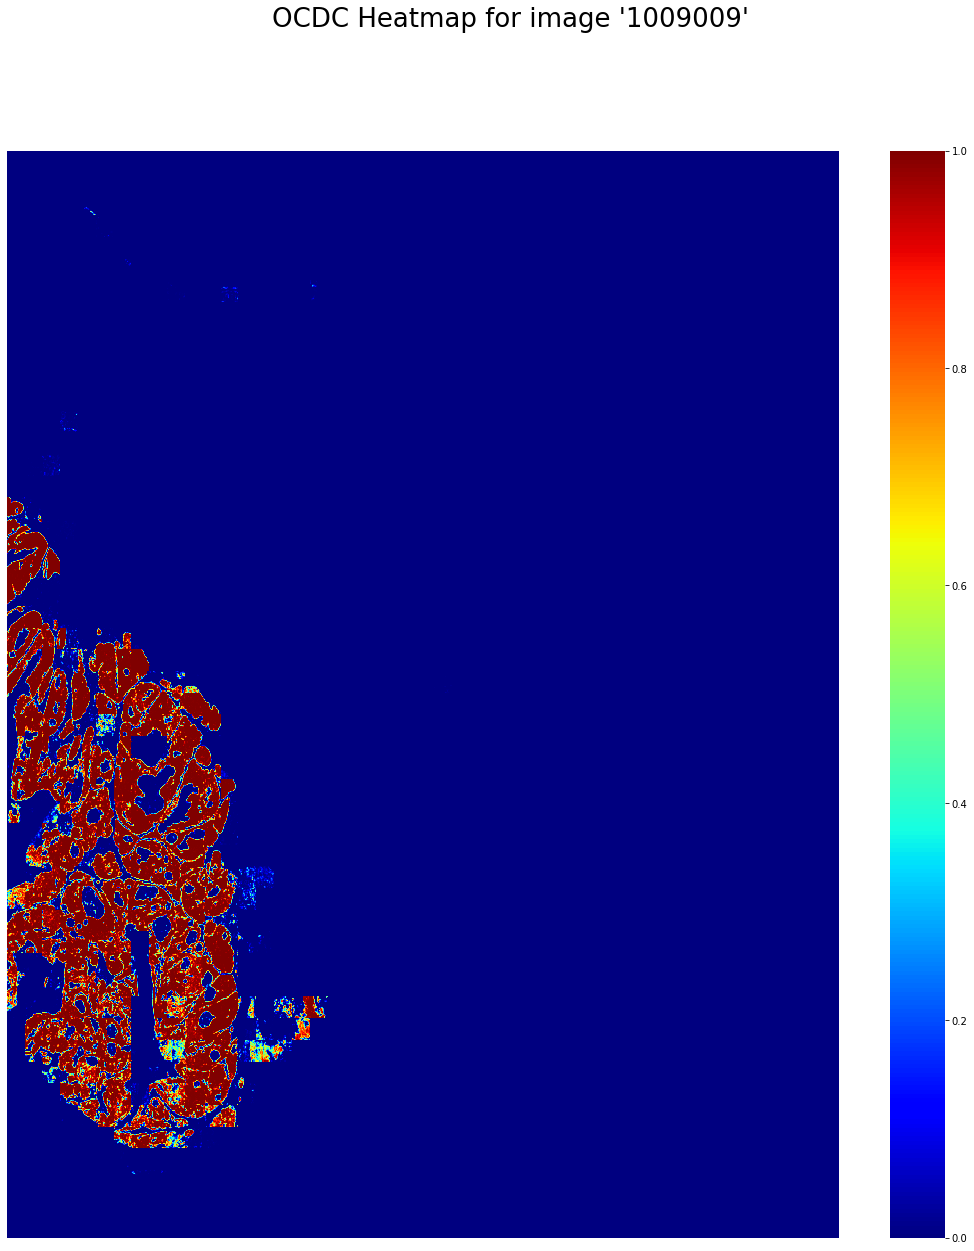

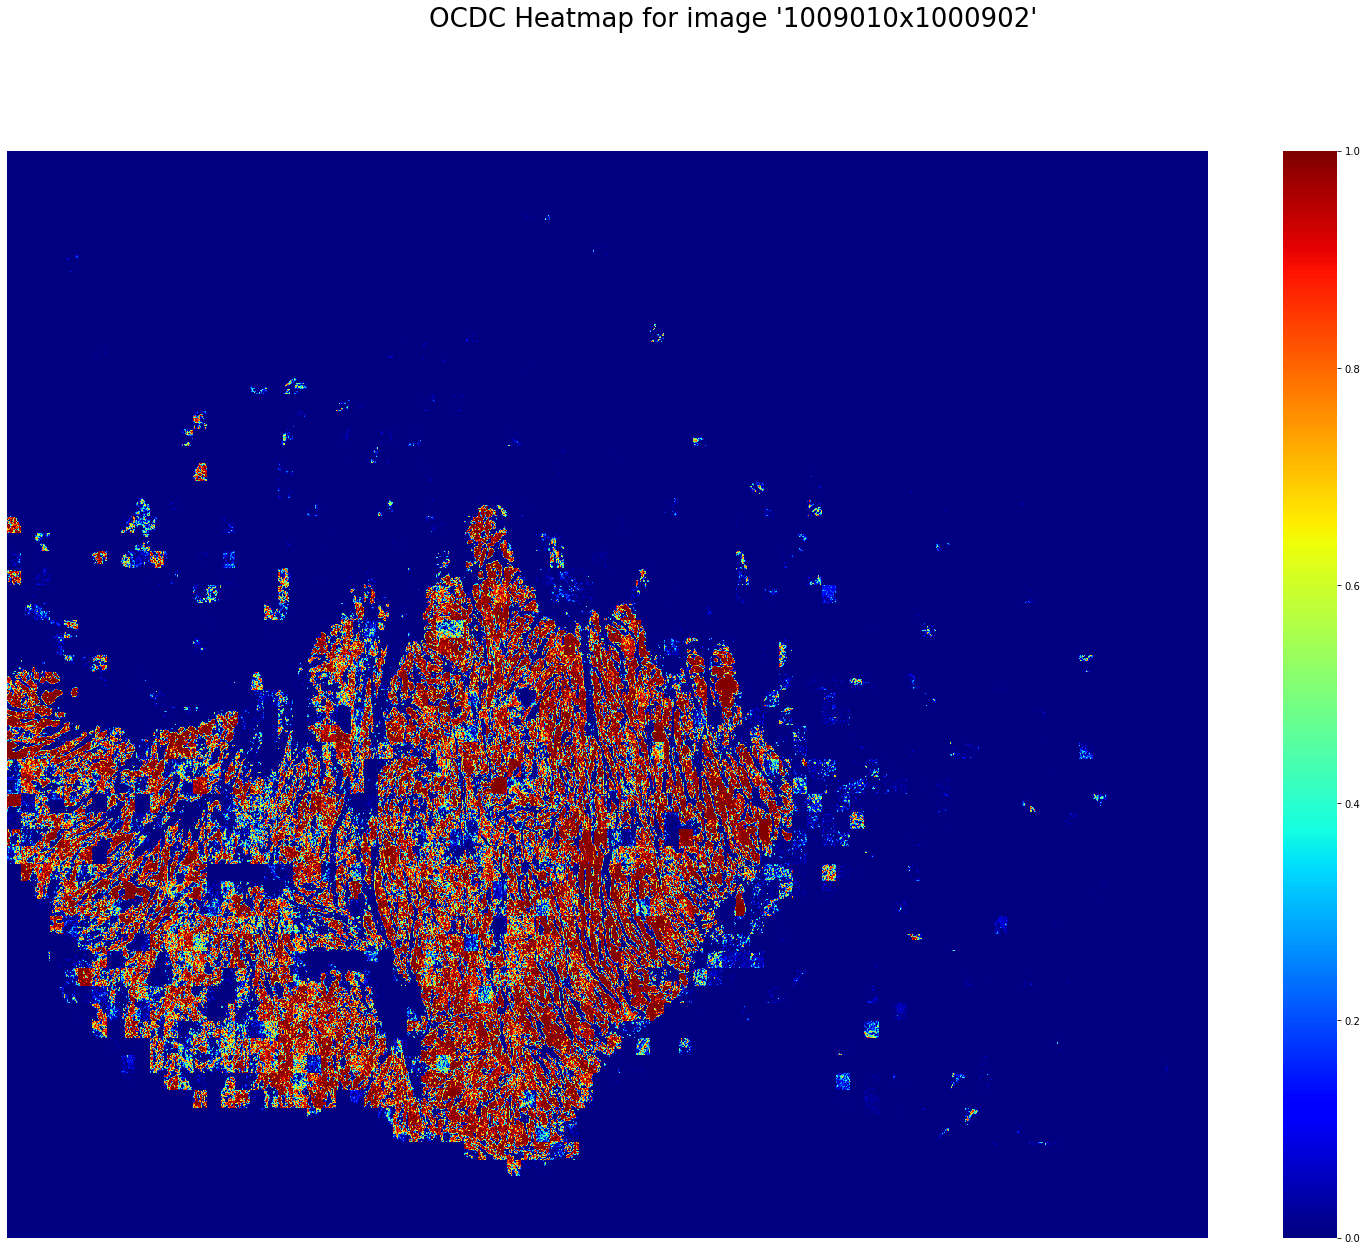

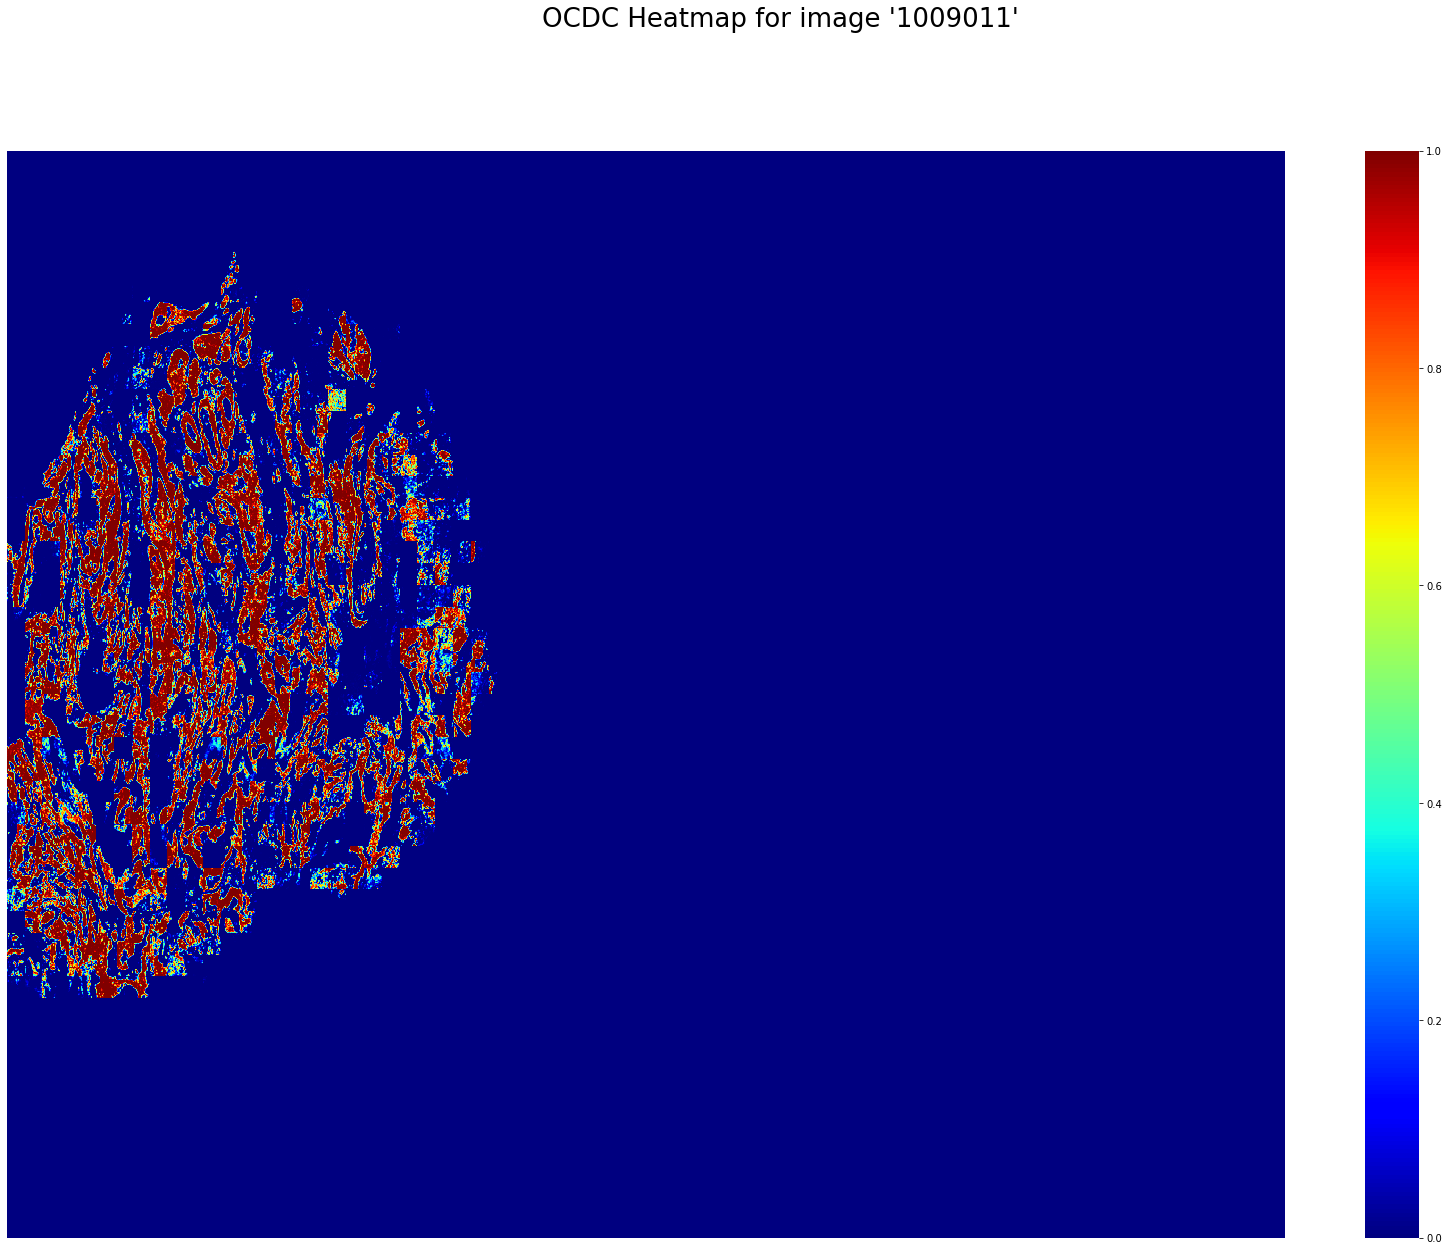

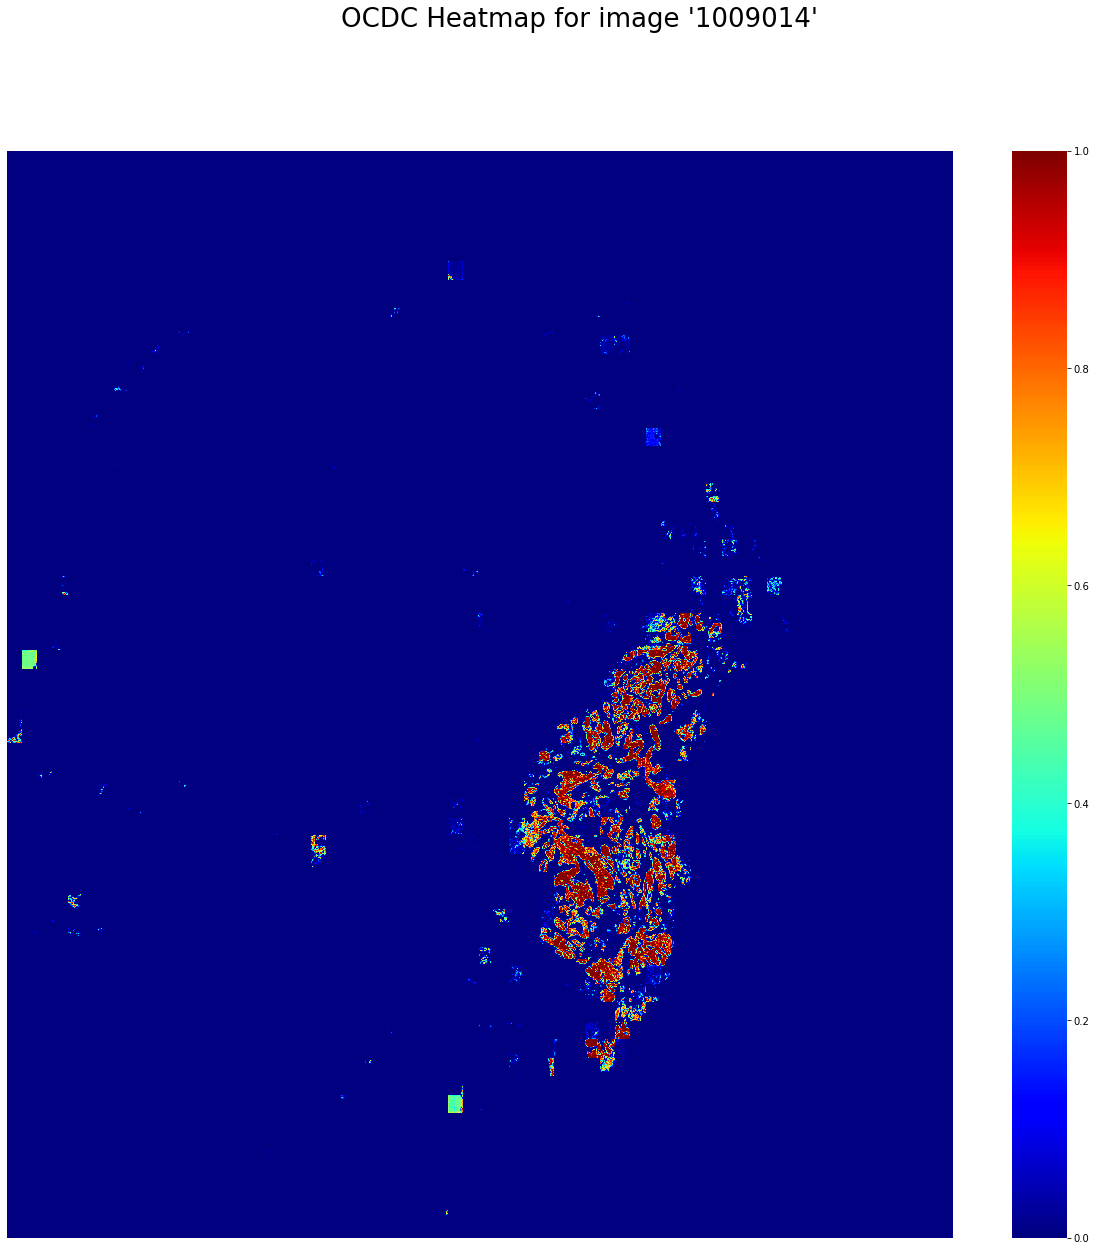

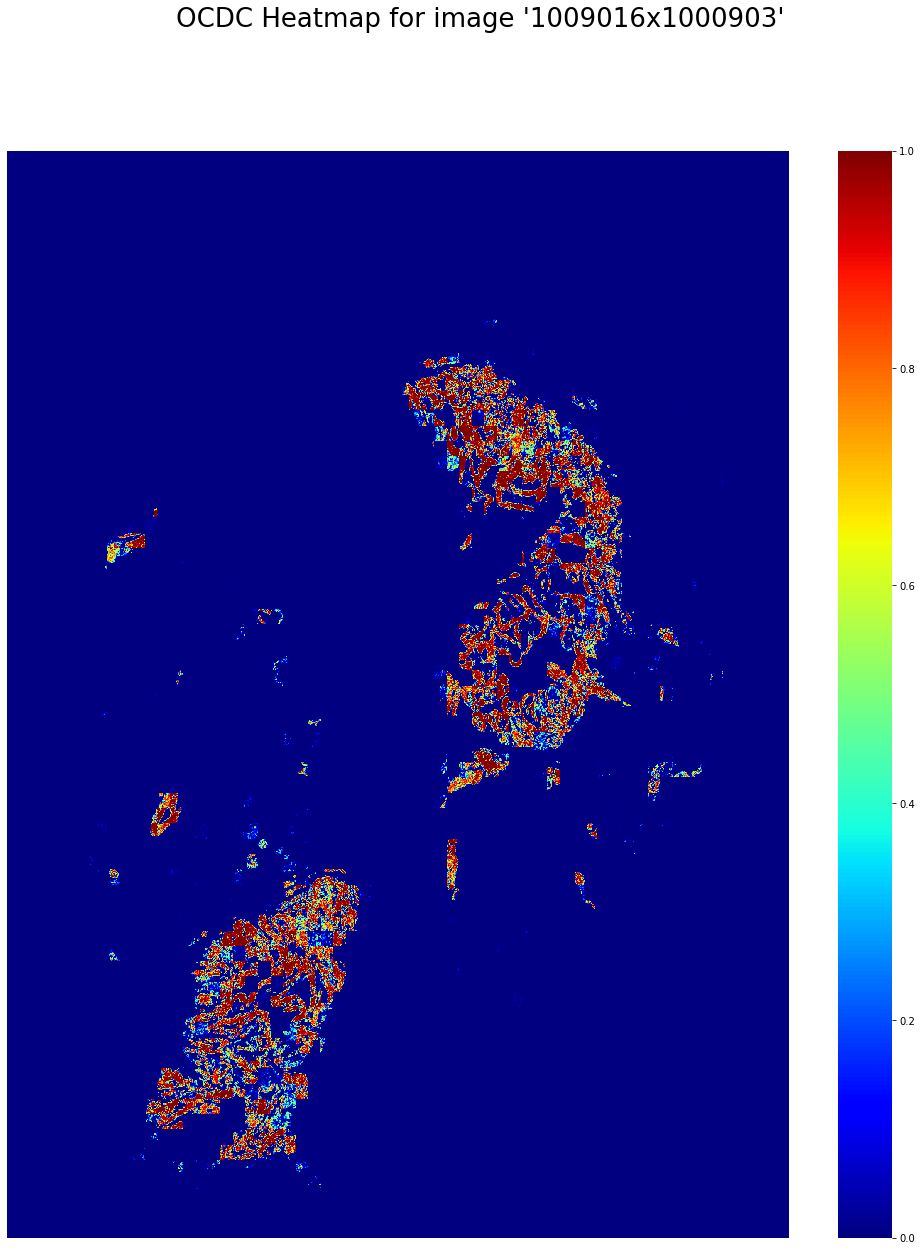

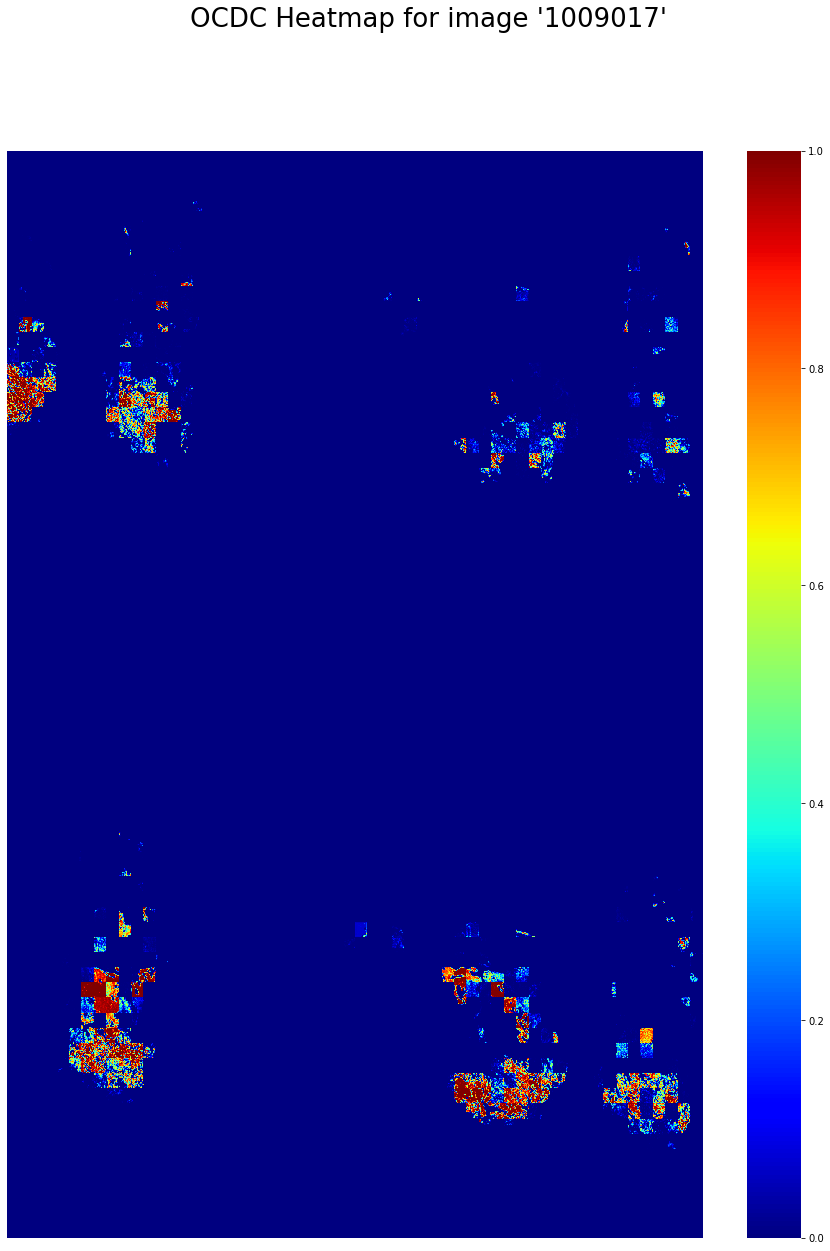

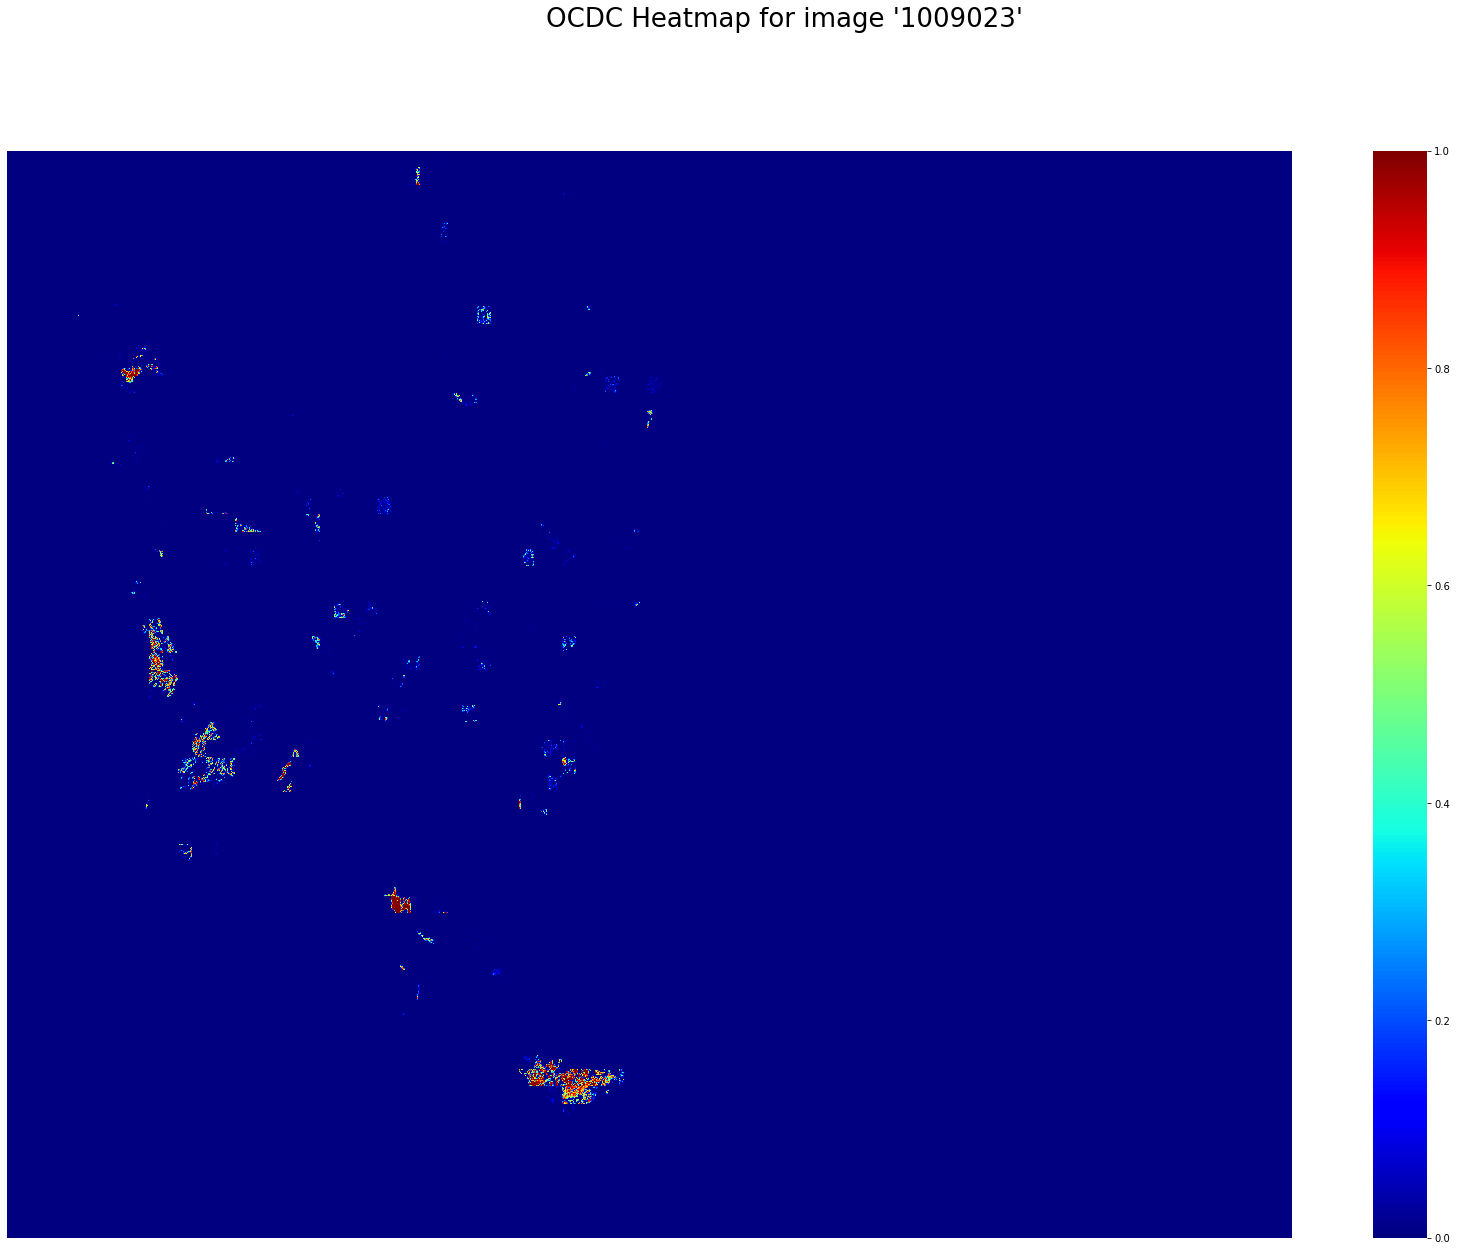

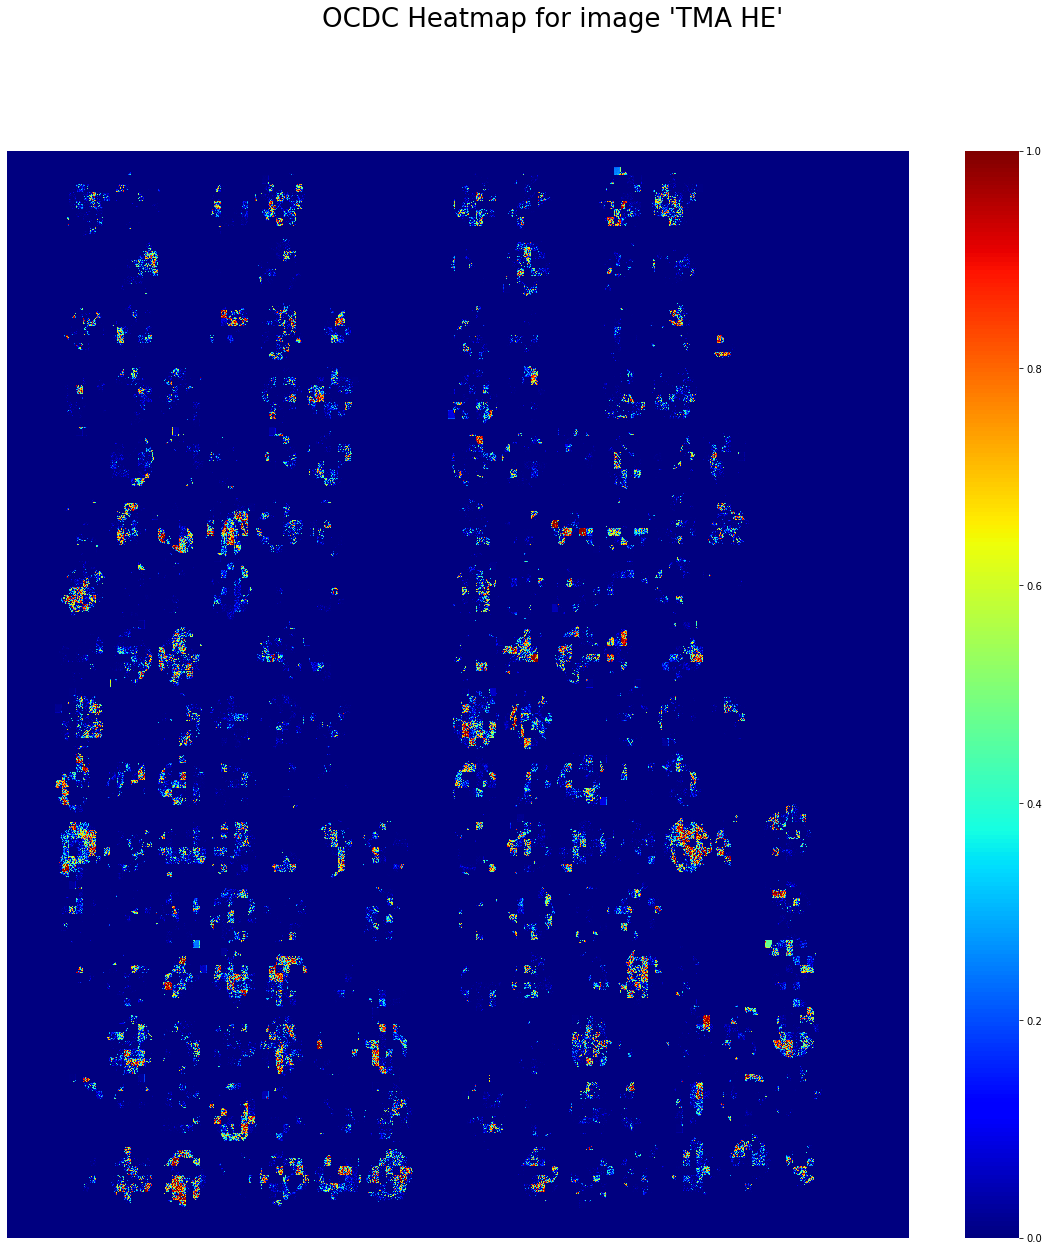

In [6]:
import os
import sys

current_path = os.path.abspath('.')
root_path = os.path.dirname(os.path.dirname(current_path))
sys.path.append(root_path)

from sourcecode.wsi_image_utils import *

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import *
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils


#dataset_dir = "../../datasets/OCDC"
dataset_dir = "/media/dalifreire/DADOS/PhD/github/tumor_regions_segmentation/datasets/OCDC"
model_dir = "../../models"
trained_model_version = "OCDC__Size-640x640_Epoch-300_Images-840_Batch-1__no_augmentation"

color_model = "LAB"
magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original)


dataset_type = "testing"
classes = ["tumor", "normal"]
for cls in classes:

    wsi_images_dir = "{}/{}/{}/wsi".format(dataset_dir, dataset_type, cls)
    patch_images_dir = "{}/{}/{}/patch/640x640".format(dataset_dir, dataset_type, cls)
    patch_images_results_dir = "{}/results/{}/{}/{}/patch/640x640".format(dataset_dir, trained_model_version, dataset_type, cls)
    wsi_images_results_dir = "{}/results/{}/{}/{}/wsi".format(dataset_dir, trained_model_version, dataset_type, cls)
    
    for r, d, f in sorted(os.walk(wsi_images_dir)):
        for wsi_file in sorted(f):

            wsi_image_file = "{}/{}".format(r, wsi_file)
            wsi_image_number = wsi_file.replace(".svs", "")
            
            file_is_tif = wsi_image_file.lower().endswith('.svs')
            if file_is_tif:

                logger.info("Segmenting wsi image: '{}'".format(wsi_file))
                unet_results_dir = "{}/{}/01-unet_result".format(patch_images_results_dir, wsi_image_number)
                if not os.path.exists(unet_results_dir):
                    logger.info("\t This WSI image was not processed by our fcn based method yet.")
                    logger.info("\t {}".format(unet_results_dir))
                    continue
                
                original_img_path = "{}/{}/{}.png".format(wsi_images_results_dir, wsi_image_number, wsi_image_number)
                pil_original_image = load_pil_image(original_img_path, gray=False)
                np_scaled_down_image = pil_to_np(pil_original_image)

                # fcn roi identification
                count_tiles = 0
                np_heatmap = np.zeros((np_scaled_down_image.shape[0], np_scaled_down_image.shape[1]))
                np_tissue_roi = np.zeros_like(np_scaled_down_image)
                for _, _, unet_tile_files in sorted(os.walk(unet_results_dir)):
                    for unet_tile_image_file in sorted(unet_tile_files):
                        if os.path.isfile("{}/{}".format(unet_results_dir, unet_tile_image_file)):

                            # load the unet image-patch result
                            np_tile_unet = np.copy(pil_to_np(load_pil_image("{}/{}".format(unet_results_dir, unet_tile_image_file), gray=True)))
                            np_tile_unet = np_tile_unet * (1.0/255)
                            np_tile_unet[np.isnan(np_tile_unet)] = 0

                            # check if exists values greather than 0.x
                            if np.any(np.unique(np_tile_unet > 0.1)):

                                aux_row_column = unet_tile_image_file.split("_")[-1].replace(".png", "").split('c')
                                row = int(aux_row_column[0].replace("r", ""))
                                column = int(aux_row_column[-1])

                                r_s = row * tile_size
                                r_e = r_s + tile_size
                                c_s = column * tile_size
                                c_e = c_s + tile_size
                                np_heatmap[r_s:r_e, c_s:c_e] = image_resize(np_tile_unet, height=tile_size)

                                np_tile_unet = basic_threshold(np_tile_unet, threshold=0.01, output_type="uint8")
                                tissue_area = tissue_percent(np_tile_unet)
                                if tissue_area > 1:

                                    count_tiles += 1

                                else:
                                    np_heatmap[r_s:r_e, c_s:c_e] = 0

                logger.info("\t '{}' tiles identified as ROI after post processing".format(count_tiles))
                logger.info("-")
                
                f = plt.figure(figsize=((np_heatmap.shape[1]*20)/np_heatmap.shape[0], 20))
                f.suptitle("{} Heatmap for image '{}'".format(trained_model_version.split("_")[0], wsi_image_number), fontsize=26)

                ax1 = f.add_subplot(111)
                sns.heatmap(np_heatmap, ax=ax1, xticklabels=False, yticklabels=False, vmin=0, vmax=1, cmap="jet", cbar=True, robust=True)

                f.savefig(original_img_path.replace("{}.png".format(wsi_image_number), "{}_heatmap.png".format(wsi_image_number)))
                utils.save_image(TF.to_tensor(np_to_pil(np_heatmap)), original_img_path.replace("{}.png".format(wsi_image_number), "{}_heatmap_gray.png".format(wsi_image_number)))

# Generate the lesion localization points (WSI level)

In [7]:
import os
import sys

current_path = os.path.abspath('.')
root_path = os.path.dirname(os.path.dirname(current_path))
sys.path.append(root_path)

from sourcecode.wsi_image_utils import *

import csv
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import *
%matplotlib inline

import torchvision.transforms.functional as TF
from torchvision import utils

from scipy import ndimage as nd
from skimage import measure

#dataset_dir = "../../datasets/OCDC"
dataset_dir = "/media/dalifreire/DADOS/PhD/github/tumor_regions_segmentation/datasets/OCDC"
model_dir = "../../models"
trained_model_version = "OCDC__Size-640x640_Epoch-300_Images-840_Batch-1__no_augmentation"

color_model = "LAB"
magnification = 0.625
scale = get_scale_by_magnification(magnification)
tile_size = 20
tile_size_original = int(scale * tile_size)
patch_size = (tile_size_original, tile_size_original)

threshold_prob = 0.5
threshold_itc = 200/(0.243 * pow(2, 5))

dataset_type = "testing"
classes = ["tumor", "normal"]
for cls in classes:

    wsi_images_dir = "{}/{}/{}/wsi".format(dataset_dir, dataset_type, cls)
    wsi_images_results_dir = "{}/results/{}/{}/{}/wsi".format(dataset_dir, trained_model_version, dataset_type, cls)

    for r, d, f in sorted(os.walk(wsi_images_dir)):
        for wsi_file in sorted(f):

            wsi_image_file = "{}/{}".format(r, wsi_file)
            wsi_image_number = wsi_file.replace(".svs", "")

            file_is_tif = wsi_image_file.lower().endswith('.svs')
            if file_is_tif:
                
                logger.info("Generating the lesion localization points for wsi image: '{}'".format(wsi_file))
                
                heatmap_gray_path = "{}/{}/{}_heatmap_gray.png".format(wsi_images_results_dir, wsi_image_number, wsi_image_number)
                if not os.path.exists(heatmap_gray_path):
                    logger.info("\t This original WSI image was not processed yet.")
                    logger.info("\t {}".format(heatmap_gray_path))
                    continue
                                
                np_heatmap_gray = load_np_image(heatmap_gray_path, color_model="GRAY") * (1.0/255)
                np_heatmap_points = np.zeros((np_heatmap_gray.shape[0], np_heatmap_gray.shape[1]))
                np_heatmap_convex = np.zeros((np_heatmap_gray.shape[0], np_heatmap_gray.shape[1]))

                seg_threshold_img = basic_threshold(np_heatmap_gray, threshold=threshold_prob, output_type="uint8")
                seg_threshold_img = nd.morphology.binary_fill_holes(seg_threshold_img)
                
                seg_threshold_img_labels = measure.label(seg_threshold_img, connectivity=2)
                seg_threshold_img = np.zeros((np_heatmap_gray.shape[0], np_heatmap_gray.shape[1]))
                
                properties = measure.regionprops(seg_threshold_img_labels)
                
                csv_file_path = heatmap_gray_path.replace("_heatmap_gray.png", ".csv")
                with open(csv_file_path, mode='w') as result_file:

                    result_writer = csv.writer(result_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
                                        
                    labels = np.unique(seg_threshold_img_labels)
                    for lbl in range(1, (np.max(labels)+1)):
                        
                        centroid = (int(properties[lbl-1].centroid[0]), int(properties[lbl-1].centroid[1]))
                        major_axis_length = properties[lbl-1].major_axis_length
                        
                        if major_axis_length > threshold_itc:

                            hull = properties[lbl-1].convex_image
                            bbox = properties[lbl-1].bbox
                            #mean_intensity = np.mean(np_heatmap_gray[bbox[0]:bbox[2], bbox[1]:bbox[3]][hull==True])
                            #centroid_intensity = np_heatmap_gray[centroid[0], centroid[1]]
                            max_intensity = np.max(np_heatmap_gray[bbox[0]:bbox[2], bbox[1]:bbox[3]][hull==True])
                                                        
                            prob = max_intensity
                            if prob > 0.0:
                                
                                #print("   {:04.2f}, {}, {}".format(prob, centroid[1], centroid[0]))
                                seg_threshold_img[seg_threshold_img_labels == lbl] = 1
                                
                                result_writer.writerow(["{:04.2f}".format(prob), centroid[1], centroid[0]])
                                np_heatmap_points[centroid[0]-10:centroid[0]+10, centroid[1]-10:centroid[1]+10] = 1
                                np_heatmap_convex[bbox[0]:bbox[2], bbox[1]:bbox[3]][hull==True] = 1
                                np_heatmap_convex[centroid[0]-10:centroid[0]+10, centroid[1]-10:centroid[1]+10] = 0.5
                        
                utils.save_image(TF.to_tensor(np_to_pil(seg_threshold_img)), heatmap_gray_path.replace("_gray", "_gray_threshold_{}".format(threshold_prob)))
                utils.save_image(TF.to_tensor(np_to_pil(np_heatmap_points)), heatmap_gray_path.replace("_gray", "_points"))
                #utils.save_image(TF.to_tensor(np_to_pil(np_heatmap_convex)), heatmap_gray_path.replace("_gray", "_gray_threshold_{}_convex".format(threshold_prob)))


2021-08-05 21:05:30,453 :: INFO <module> :: Generating the lesion localization points for wsi image: '1009009.svs'
2021-08-05 21:05:30,711 :: INFO <module> :: Generating the lesion localization points for wsi image: '1009010x1000902.svs'
2021-08-05 21:05:31,927 :: INFO <module> :: Generating the lesion localization points for wsi image: '1009011.svs'
2021-08-05 21:05:32,535 :: INFO <module> :: Generating the lesion localization points for wsi image: '1009014.svs'
2021-08-05 21:05:32,947 :: INFO <module> :: Generating the lesion localization points for wsi image: '1009016x1000903.svs'
2021-08-05 21:05:33,585 :: INFO <module> :: Generating the lesion localization points for wsi image: '1009017.svs'
2021-08-05 21:05:34,043 :: INFO <module> :: Generating the lesion localization points for wsi image: '1009023.svs'
2021-08-05 21:05:34,474 :: INFO <module> :: Generating the lesion localization points for wsi image: 'TMA HE.svs'


# Execute the trained model (image-patch level)

In [3]:
import os
import sys

current_path = os.path.abspath('.')
root_path = os.path.dirname(os.path.dirname(current_path))
sys.path.append(root_path)

from sourcecode.OCDC.ocdc_train import *
from sourcecode.OCDC.ocdc_dataloader import *

import torchvision.transforms.functional as TF
from torchvision import transforms
from torchvision import utils
from datetime import datetime

from scipy import ndimage as nd
from skimage import measure

#dataset_dir = "../../datasets/OCDC"
dataset_dir = "/media/dalifreire/DADOS/PhD/github/tumor_regions_segmentation/datasets/OCDC"
model_dir = "../../models"

batch_size = 1
patch_size = (640, 640)
color_model = "LAB"
dataloaders = create_dataloader(tile_size="{}x{}".format(patch_size[0], patch_size[1]),
                                batch_size=batch_size, 
                                shuffle=False,
                                img_input_size=patch_size,
                                img_output_size=patch_size,
                                dataset_dir=dataset_dir,
                                color_model=color_model)

dataset_train_size = len(dataloaders['train'].dataset)
dataset_test_size = len(dataloaders['test'].dataset)


threshold_prob = 0.50
threshold_itc = 200/(0.243 * pow(2, 5))


# Checking for GPU availability
use_cuda=True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if use_cuda else "cpu"
logger.info('Runing on: {}'.format(device))

# loads our trained fcn model
trained_model_version = "OCDC__Size-640x640_Epoch-300_Images-840_Batch-1__no_augmentation"
trained_model_path="{}/{}".format(model_dir, '{}.pth'.format(trained_model_version))
model = load_checkpoint(file_path=trained_model_path, img_input_size=patch_size, use_cuda=use_cuda)
cont = 0
for batch_idx, (images, masks, fname, original_size) in enumerate(dataloaders['test']):
        
    X = Variable(images).to(device) if use_cuda else images
    logger.info('Batch {}: {}/{} images: {} masks: {} {}'.format(
                (batch_idx+1), 
                (batch_idx+1) * len(images), 
                len(dataloaders['test'].dataset),
                images.shape,
                masks.shape,
                datetime.now().strftime('%d/%m/%Y %H:%M:%S')))
    
    #X_numpy = X.cpu().numpy()
    y_hat = model(X).detach().cpu().squeeze(0)
    cls = "tumor" if np.max(np.unique(masks[0].numpy())) > 0 else 'normal'
    
    input_image = transforms.ToPILImage()(X.squeeze(0).cpu())
    output_mask = basic_threshold(y_hat[0].detach().cpu().numpy(), threshold=threshold_prob, output_type="uint8")

    predicted_labels = measure.label(output_mask, connectivity=2)
    output_mask = np.zeros((output_mask.shape[0], output_mask.shape[1]))
    labels = np.unique(predicted_labels)
    properties = measure.regionprops(predicted_labels)
    for lbl in range(1, (np.max(labels)+1)):
        major_axis_length = properties[lbl-1].major_axis_length
        if major_axis_length > threshold_itc:
            output_mask[predicted_labels == lbl] = 1

    input_image_rgb = lab_to_rgb(pil_to_np(input_image))
    roi_image = blend_image(np_to_pil(input_image_rgb), np_to_pil(output_mask), foreground='red', alpha=0.6, inverse=True)

    # results dir
    wsi_image_number = fname[0].split("_")[0]
    patch_images_results_dir = "{}/results/{}/testing/{}/patch/640x640/{}".format(dataset_dir, trained_model_version, cls, wsi_image_number)
    
    results_output_dir = "{}/01-unet_result".format(patch_images_results_dir)
    if not os.path.exists(results_output_dir):
        os.makedirs(results_output_dir)
    
    results_roi_dir = "{}/02-roi".format(patch_images_results_dir)
    if not os.path.exists(results_roi_dir):
        os.makedirs(results_roi_dir)

    # save the results
    patch_img_name = fname[0]
    utils.save_image(y_hat[0], '{}/{}'.format(results_output_dir, patch_img_name))
    utils.save_image(TF.to_tensor(roi_image), '{}/{}'.format(results_roi_dir, patch_img_name))

2021-05-17 21:14:31,095 :: INFO load_dataset :: [training] ../../datasets/OCDC/training
2021-05-17 21:14:31,185 :: INFO load_dataset :: [training] ../../datasets/OCDC/training
2021-05-17 21:14:31,267 :: INFO load_dataset :: [testing] ../../datasets/OCDC/testing
2021-05-17 21:14:31,336 :: INFO create_dataloader :: Train images (640x640): 840 augmentation: random
2021-05-17 21:14:31,337 :: INFO create_dataloader :: Test images (640x640): 180 augmentation: no_augmentation
2021-05-17 21:14:31,338 :: INFO <module> :: Runing on: cpu
2021-05-17 21:14:31,918 :: INFO load_checkpoint :: 	 Model loaded on: cpu / 3 / 1 / (640, 640) -> ../../models/OCDC__Size-640x640_Color-LAB_Epoch-500_Images-840_Batch-1.pth
2021-05-17 21:14:32,057 :: INFO transform :: Epoch: '1' augmentation no_augmentation None
2021-05-17 21:14:32,090 :: INFO <module> :: Batch 1: 1/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:14:32
2021-05-17 21:14:38,736 :: INFO <module> :: Batch 2: 2/

2021-05-17 21:22:46,627 :: INFO <module> :: Batch 51: 51/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:22:46
2021-05-17 21:22:56,214 :: INFO <module> :: Batch 52: 52/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:22:56
2021-05-17 21:23:04,116 :: INFO <module> :: Batch 53: 53/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:23:04
2021-05-17 21:23:12,772 :: INFO <module> :: Batch 54: 54/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:23:12
2021-05-17 21:23:21,787 :: INFO <module> :: Batch 55: 55/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:23:21
2021-05-17 21:23:29,429 :: INFO <module> :: Batch 56: 56/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:23:29
2021-05-17 21:23:38,151 :: INFO <module> :: Batch 57: 57/180 images: torch.Size([1, 3, 640, 64

2021-05-17 21:30:36,697 :: INFO <module> :: Batch 106: 106/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:30:36
2021-05-17 21:30:44,541 :: INFO <module> :: Batch 107: 107/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:30:44
2021-05-17 21:30:52,989 :: INFO <module> :: Batch 108: 108/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:30:52
2021-05-17 21:31:00,819 :: INFO <module> :: Batch 109: 109/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:31:00
2021-05-17 21:31:08,447 :: INFO <module> :: Batch 110: 110/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:31:08
2021-05-17 21:31:16,058 :: INFO <module> :: Batch 111: 111/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:31:16
2021-05-17 21:31:23,699 :: INFO <module> :: Batch 112: 112/180 images: torch.Size(

2021-05-17 21:38:05,354 :: INFO <module> :: Batch 160: 160/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:38:05
2021-05-17 21:38:14,954 :: INFO <module> :: Batch 161: 161/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:38:14
2021-05-17 21:38:24,005 :: INFO <module> :: Batch 162: 162/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:38:24
2021-05-17 21:38:32,071 :: INFO <module> :: Batch 163: 163/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:38:32
2021-05-17 21:38:43,271 :: INFO <module> :: Batch 164: 164/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:38:43
2021-05-17 21:38:53,085 :: INFO <module> :: Batch 165: 165/180 images: torch.Size([1, 3, 640, 640]) masks: torch.Size([1, 640, 640]) 17/05/2021 21:38:53
2021-05-17 21:39:02,513 :: INFO <module> :: Batch 166: 166/180 images: torch.Size(